# Customer segmentation

## data preparation

In [15]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing 

In [24]:
# import aggregated data of customers from R
train_data = pd.read_csv('cust.csv')
train_data2 = train_data.dropna()
train_data3 = train_data2.iloc[:,1:8]

In [25]:
# check the dataset
train_data3.head()

,revenue_sum,profit_sum,visitcnt_sum,prodcnt_avg,dispercent,cateskew,storeskew
0,9747.21,5987.198241,443,18.636085,0.182725,2.764834,0.749950
1,10107.31,6018.799721,353,20.486684,0.306022,2.836385,0.384888
2,7392.69,3293.592152,602,11.499719,0.382083,3.720312,0.380937
3,5375.40,2515.793601,191,21.629045,0.523283,2.538427,1.298857
4,9665.97,4004.741900,353,15.181325,0.584671,1.957431,1.073118


In [33]:
# scaling the potential used columns using the min-max method
mm_scaler = preprocessing.MinMaxScaler()
x_train_minmax = mm_scaler.fit_transform(train_data3)

C:\Users\feifa\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [35]:
# change the data type back to dataframe
train_data3 = pd.DataFrame(x_train_minmax)

In [37]:
# recover the column names
train_data3.columns = train_data2.iloc[:,1:8].columns

## k-means modeling

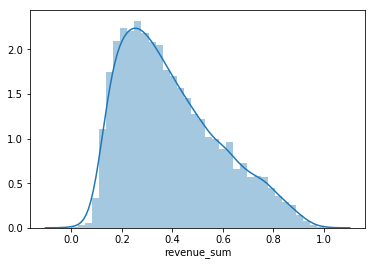

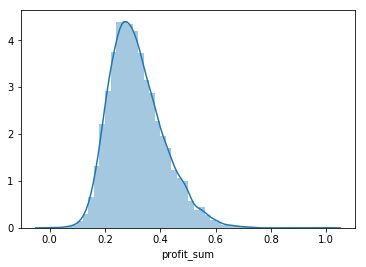

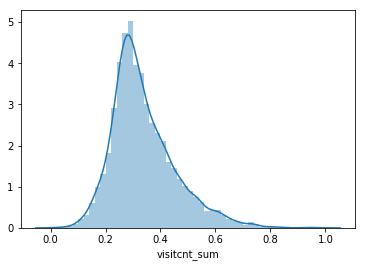

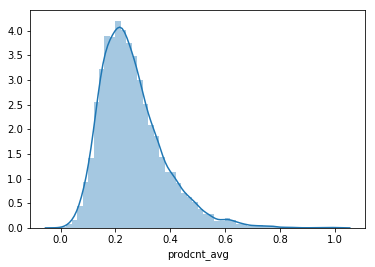

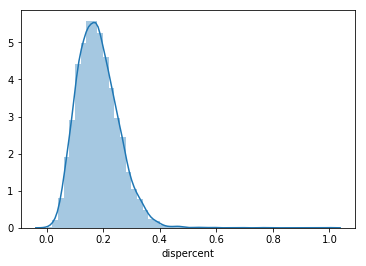

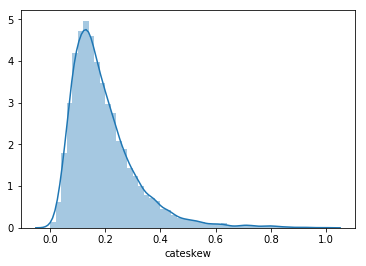

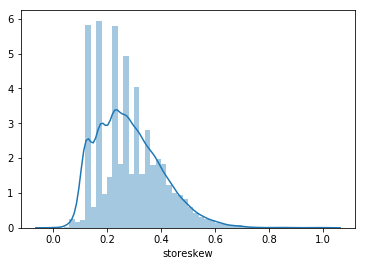

In [38]:
# check the histograms of every column
for i, col in enumerate(train_data3.iloc[:,0:7].columns):
    plt.figure(i)
    sns.distplot(train_data3.iloc[:,0:7][col])

In [39]:
# define a gap statstic function to find the best k
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [47]:
# find the best k
k, gapdf = optimalK(train_data3.iloc[:,[2,3,4,5,6]], nrefs=5, maxClusters=9)
print ('Optimal k is: ', k)

Optimal k is:  5


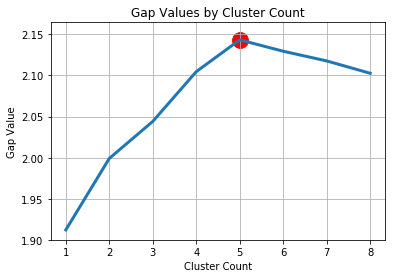

In [48]:
# plot the gap values by k
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [49]:
# since 5 clusters is the best, I extract the model with 5 clusters
km = KMeans(
    n_clusters=5, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=42
)
y_km = km.fit_predict(train_data3.iloc[:,2:7])

In [50]:
# print all the labels (clustering index) of customers
np.set_printoptions(threshold=sys.maxsize)
y_km

array([2, 0, 2, 4, 0, 0, 4, 3, 0, 3, 0, 0, 3, 4, 0, 4, 0, 0, 2, 0, 0, 3,
       1, 0, 0, 2, 3, 4, 2, 2, 2, 0, 3, 2, 3, 3, 4, 3, 0, 3, 0, 4, 4, 4,
       2, 0, 4, 2, 3, 0, 4, 0, 0, 0, 0, 3, 2, 0, 0, 4, 3, 0, 4, 0, 0, 3,
       0, 3, 0, 3, 2, 2, 0, 3, 1, 0, 0, 4, 0, 4, 2, 3, 1, 0, 4, 3, 0, 4,
       0, 3, 0, 0, 3, 4, 0, 0, 0, 3, 3, 2, 4, 3, 0, 4, 1, 4, 4, 3, 2, 4,
       3, 2, 0, 2, 2, 2, 3, 0, 2, 1, 0, 0, 3, 1, 3, 4, 0, 2, 4, 0, 1, 3,
       2, 4, 0, 0, 0, 4, 4, 0, 0, 0, 3, 2, 3, 3, 1, 1, 1, 3, 3, 3, 3, 4,
       0, 4, 0, 3, 3, 1, 0, 0, 3, 2, 4, 3, 4, 0, 0, 2, 1, 4, 0, 2, 3, 3,
       1, 4, 4, 0, 0, 4, 3, 4, 2, 2, 0, 4, 0, 3, 0, 1, 4, 1, 3, 2, 3, 0,
       2, 0, 0, 3, 1, 4, 0, 0, 3, 4, 1, 0, 3, 3, 0, 0, 0, 3, 1, 0, 2, 3,
       3, 3, 0, 4, 4, 4, 1, 2, 0, 0, 1, 1, 3, 4, 3, 0, 2, 2, 2, 3, 4, 3,
       0, 4, 0, 0, 4, 4, 4, 0, 3, 4, 0, 0, 1, 0, 2, 0, 2, 2, 4, 3, 2, 2,
       0, 3, 2, 3, 3, 0, 3, 0, 3, 0, 3, 4, 3, 3, 4, 4, 0, 4, 3, 3, 2, 0,
       3, 2, 2, 3, 3, 3, 3, 0, 0, 0, 2, 0, 4, 0, 0,

In [51]:
# cluster centers
km.cluster_centers_

array([[0.29366508, 0.23271727, 0.18407819, 0.16056235, 0.20939067],
       [0.39202978, 0.19083445, 0.15685697, 0.46537624, 0.2616893 ],
       [0.51590298, 0.1789597 , 0.15210556, 0.20764999, 0.24677625],
       [0.32521383, 0.25166693, 0.19511886, 0.1639903 , 0.43389218],
       [0.25256457, 0.45312456, 0.20026372, 0.13817731, 0.2749006 ]])